<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-imports-and-folder-paths" data-toc-modified-id="Setup-imports-and-folder-paths-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup imports and folder paths</a></span></li><li><span><a href="#Creating-the-map" data-toc-modified-id="Creating-the-map-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Creating the map</a></span><ul class="toc-item"><li><span><a href="#Extracting-the-corners" data-toc-modified-id="Extracting-the-corners-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Extracting the corners</a></span></li></ul></li><li><span><a href="#Connection-to-the-Thymio" data-toc-modified-id="Connection-to-the-Thymio-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Connection to the Thymio</a></span></li><li><span><a href="#Moving-the-Thymio" data-toc-modified-id="Moving-the-Thymio-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Moving the Thymio</a></span></li></ul></div>

## Setup imports and folder paths

In [1]:
# ========================================================================== #
#  Imports.                                                                  # 
# ========================================================================== #

import os
import sys
import matplotlib.pyplot as plt

# ========================================================================== #
#  Folder paths.                                                             # 
# ========================================================================== #

sys.path.insert(1, 'src')
sys.path.insert(1, 'img')

## Creating the map
The map is created using the functions defined in the file **create_map.py**. The first step is to be able to rectify the image taken by the camera. This is done by using red markers for each corner of the map, and using their position to compute a transform matrix that will be used to get a rectified image.

In [2]:
# ========================================================================== #
#  Imports.                                                                  # 
# ========================================================================== #

from create_map import *
from img_utils import *

# Read different images to test the robustness of the map creation process
img = cv2.imread('img/map_test2.png')
img_noisy = cv2.imread('img/map_test_noisy.png')
img_vert = cv2.imread('img/map_test4.png')

### Extracting the corners
This is simply done by converting the map into HSV color space. We can then easily extract the color using a range of angles and luminances.

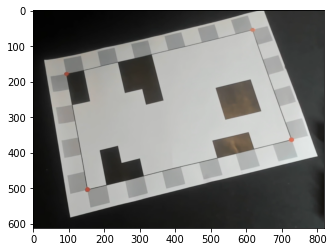

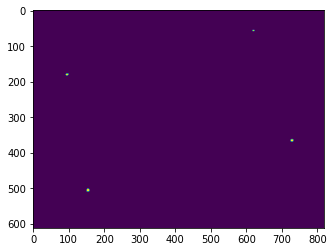

In [3]:
# convert to hsv space
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# extract a certain color
mask = cv2.inRange(hsv, RED_THR_HSV_LOW, RED_THR_HSV_HIGH)
# erode mask to avoid noise
kernel = np.ones((2,2),np.uint8)
mask = cv2.erode(mask,kernel,iterations = 3)

plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.figure()
plt.imshow(mask)

We can then extract the coordinates of the corners. The corners are sorted from biggest dot to smallest dot. This is done to be able to select the dots that are less likely to be noise (we can specify how many dots we expect to be returned). The corners are calculated by computing the centroid of the dots.

Noisy picture: [(702, 466), (108, 465), (139, 136), (679, 130), (256, 365)]
Noisy picture, 4 biggest dots: [(702, 466), (108, 465), (139, 136), (679, 130)]
Found all dots.
Failed to find the requested number of dots.


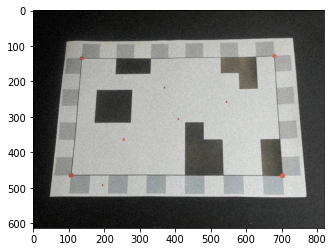

In [4]:
dots, found_dots = get_color_dots(img_noisy, RED_THR_HSV_LOW, RED_THR_HSV_HIGH)
plt.figure()
plt.imshow(cv2.cvtColor(img_noisy, cv2.COLOR_BGR2RGB))
# With a noisy picture, we get more than 4 corners.
print("Noisy picture: {}".format(dots))

# We can filter this by specifying how many dots we expect
dots, found_dots = get_color_dots(img_noisy, RED_THR_HSV_LOW, RED_THR_HSV_HIGH, 4)
print("Noisy picture, 4 biggest dots: {}".format(dots))
if found_dots:
    print("Found all dots.")
else:
    print("Failed to find the requested number of dots.")

# The function returns False if we try to get more dots than there are on the picture
dots, found_dots = get_color_dots(img_noisy, RED_THR_HSV_LOW, RED_THR_HSV_HIGH, 6)
if found_dots:
    print("Found all dots.")
else:
    print("Failed to find the requested number of dots.")

Below is an example of a map creation from a picture. The function **create_map** returns the transform matrix used to rectify the image, the width and height of the rectified image, the map and its enlarged version as matrices, and a boolean value indicating if the map was successfully computed. The **create_map** function has to be called with known dimensions (known number of cells in the x and y axis).

Image dimensions are 819 x 613
Map corner: x: 702, y: 466
Map corner: x: 108, y: 465
Map corner: x: 139, y: 136
Map corner: x: 679, y: 130
Image center is (407.0, 299.25)
Top left (139, 136)
Top Right (679, 130)
Bottom left (108, 465)
Bottom right (702, 466)
Rectified image dimensions are 800 x 509


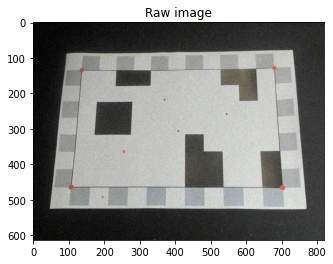

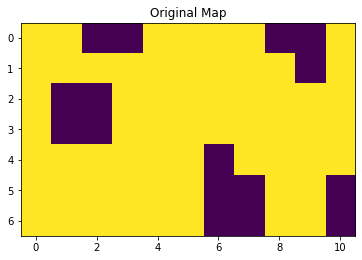

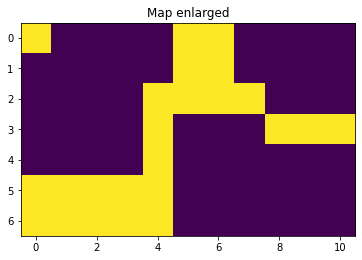

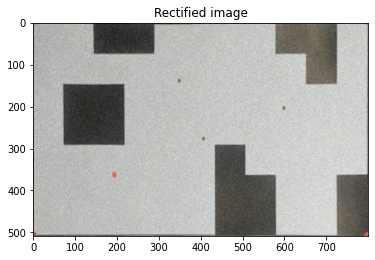

In [5]:
# ========================================================================== #
#  Example 1                                                                 # 
# ========================================================================== #

plt.figure()
plt.imshow(cv2.cvtColor(img_noisy, cv2.COLOR_BGR2RGB))
plt.title("Raw image")

# Initialize map
M, rect_width, rect_height, map, map_enlarged, success = create_map(img_noisy, 11, 7, verbose = True)
if success:
    
    plt.figure()
    plt.imshow(map, origin = 'lower')
    plt.title("Original Map")
    plt.gca().invert_yaxis()
    
    plt.figure()
    plt.imshow(map_enlarged, origin = 'lower')
    plt.title("Map enlarged")
    plt.gca().invert_yaxis()
    
    # We can now get the rectified image using the warp transform matrix
    # Separating the processes allow us to recalculate quickly the rectified map
    # without having to recalculate the warp transform matrix (assuming fixed camera).
    img_rect = get_rectified_img(img_noisy, M, rect_width, rect_height)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_rect, cv2.COLOR_BGR2RGB))
    plt.title("Rectified image")
    plt.show()
else:
    print("Map was not successfully computed.")

Image dimensions are 819 x 612
Map corner: x: 154, y: 505
Map corner: x: 728, y: 365
Map corner: x: 95, y: 180
Map corner: x: 620, y: 57
Image center is (399.25, 276.75)
Top left (95, 180)
Top Right (620, 57)
Bottom left (154, 505)
Bottom right (728, 365)
Rectified image dimensions are 800 x 509


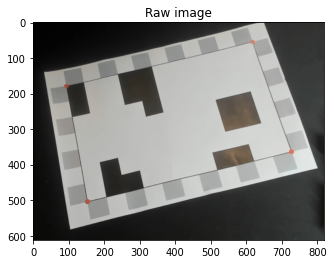

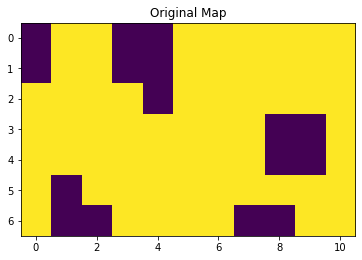

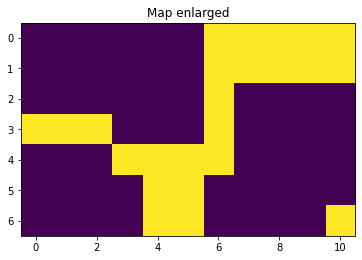

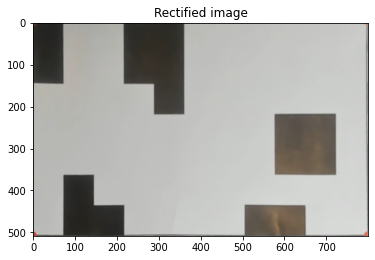

In [6]:
# ========================================================================== #
#  Example 2                                                                 # 
# ========================================================================== #

plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Raw image")

# Initialize map
M, rect_width, rect_height, map, map_enlarged, success = create_map(img, 11, 7, verbose = True)
if success:
    
    plt.figure()
    plt.imshow(map, origin = 'lower')
    plt.title("Original Map")
    plt.gca().invert_yaxis()
    
    plt.figure()
    plt.imshow(map_enlarged, origin = 'lower')
    plt.title("Map enlarged")
    plt.gca().invert_yaxis()
    
    # We can now get the rectified image using the warp transform matrix
    # Separating the processes allow us to recalculate quickly the rectified map
    # without having to recalculate the warp transform matrix (assuming fixed camera).
    img_rect = get_rectified_img(img, M, rect_width, rect_height)
    plt.figure()
    plt.imshow(cv2.cvtColor(img_rect, cv2.COLOR_BGR2RGB))
    plt.title("Rectified image")
    plt.show()
else:
    print("Map was not successfully computed.")

## Connection to the Thymio

To ensure that the program can be run on different computers and with different connection types (cable, wireless), we first identify the Thymio VID (Vendor ID) and put it in a list (in case of multiple Thymios, we can have multiple VIDs). When connecting, the program checks for the VID of each serial port, and initiates a communication if a matching VID is found.

In [7]:
# ========================================================================== #
#  Imports.                                                                  # 
# ========================================================================== #

from thymio_connection import *
import time

First, display ports VIDs. This will then have to be manually put in the **THYMIO_VID** list which contains a list of possible VIDs.

In [8]:
check_vid()

Port: COM9, VID: 9025
Port: COM15, VID: 1027
Port: COM16, VID: None
Port: COM8, VID: None
Port: COM11, VID: None
Port: COM22, VID: None
Port: COM13, VID: None
Port: COM10, VID: None
Port: COM12, VID: None
Port: COM21, VID: None
Port: COM19, VID: 1559


It is then possible to automatically connect to the right port, if the matching VID is found.

In [9]:
th = connect_to_thymio(num_err = 20, verbose = True)

Connecting to Thymio. Try 1/20...
Successfully connected to thymio on COM19.


In [12]:
# Try to read from the Thymio
for i in range(10):
    try:
        print(th["prox.horizontal"])
    except KeyError:
        pass
    time.sleep(0.2)

[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[3069, 3435, 3381, 0, 0, 0, 0]
[3458, 3660, 3624, 3777, 0, 0, 0]
[3398, 3661, 3680, 4231, 0, 0, 0]
[3212, 3512, 3244, 3829, 0, 0, 0]
[3175, 3114, 2590, 0, 0, 0, 0]


## Moving the Thymio